In [1]:
# import python packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy import signal
import pylab
from pykalman import KalmanFilter
import time
from sklearn.decomposition import FactorAnalysis
import pickle

In [2]:
# local own implementations
%load_ext autoreload
%autoreload 2
from Bouroukan2017 import spiking, rasterplot
from PLDS_Macke2015 import PLDS, vis_est_latent
#from PLDS_Macke2015_evaluation import fit_to_all_trials

def concat_trials(SPIKES, counts0, X=None):
    YTMP = np.copy(SPIKES[:counts0[0], :, 0])
    if X is not None: XTMP = np.copy(X[:counts0[0], :, 0])
    else: XTMP = X

    for tt in range(1, len(counts0)):
        YTMP = np.concatenate([YTMP, SPIKES[:counts0[tt], :, tt]])
        if X is not None: XTMP = np.concatenate([XTMP, X[:counts0[tt], :, tt]])
    return XTMP, YTMP

# simulate data

## simulate LDS latent and PLDS data

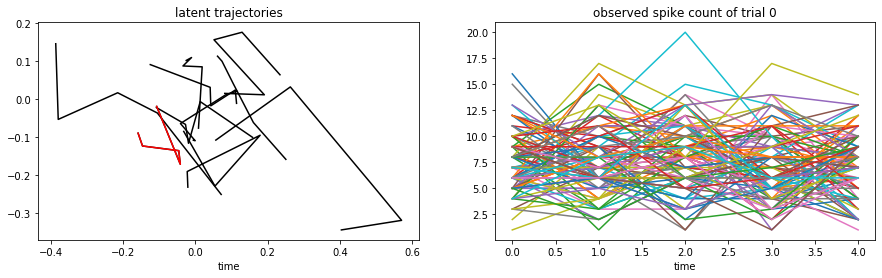

In [22]:

#### parameters used ####
seed =6
np.random.seed(seed)
# linear Gaussian
n_step_sig = np.array([5])
Ttrials = 10

# latent
xdim = 2
A = 0.999999*np.eye(xdim) # np.array([[0.9, 0.1],  [0.3, 0.7]]) #np.array([[0., 1.],[-4., 0.]])* np.array([.5])#  *  #  np.eye(xdim) # 
sigQ = 0.01 #.5
Q = np.eye(xdim)*sigQ # np.array([[1, 0.1],[0.1, 1]]) # 
Q0 = np.eye(xdim)*sigQ
x0 = np.zeros(xdim)
# rate
ydim = 100
cscal = 1
C = cscal* np.random.randn(ydim*xdim).reshape(ydim, xdim)

MOD = PLDS()
MOD.par(xdim=xdim, ydim=ydim, n_step=n_step_sig, C=C, Q0=Q0, A=A, Q=Q, x0=x0, 
        Ttrials=Ttrials, B=2*np.ones([ydim,1]))
MOD.sample()
yold = np.copy(MOD.y)
Cold = np.copy(MOD.C)
MOD.vis_xy()
#MOD.vis_xzy(cho_ydim=np.argmax(C[:,0]))

## encoding

### adjust signal for neurons

In [43]:
import pickle
with open('/Users/carolinehaimerl/Downloads/Wang_wiggles.pickle', 'rb') as handle:
    a = pickle.load(handle)

In [47]:
a.shape

(2, 50000, 10)

In [23]:
# upsample for neurons:

# Numerical Simulation parameters
dt = 1e-4
dtsign = 1
tmax = np.max(MOD.n_step)*dtsign
timed = np.arange(0,tmax,dt)
n_step = len(timed)
signscal = 10 # scal the signal in a +/- this value range to fit for the neuron
print(n_step)
print(tmax)

newT = np.array(tmax/dt,dtype='int')
print(newT)

50000
5
50000


In [48]:
ma_x = np.zeros([MOD.xdim, newT, MOD.Ttrials])
# interpolate
for tt in range(MOD.Ttrials):    
    f1 = interpolate.interp1d(np.arange(tmax), a[:,0,tt], kind='cubic')
    if MOD.xdim==2: f2 = interpolate.interp1d(np.arange(tmax), a[:,1,tt], kind='cubic')

    xnew = np.linspace(0, tmax-1, n_step)
    if MOD.xdim==1: 
        x_ups = np.array([f1(xnew)])
    if MOD.xdim==2:
        x_ups = np.array([f1(xnew), f2(xnew)])
    
    # ... and scale
    
    for ii in range(MOD.xdim):
        ma_x[ii,:,tt] = ((x_ups[ii,:]-np.min(x_ups[ii,:]))/(np.max(x_ups[ii,:])-np.min(x_ups[ii,:]))*2-1)*signscal
if MOD.xdim==1: 
    plt.plot(xnew, ma_x[0,:,tt], 'g', label='upsampled+scal')
    plt.plot(xnew, x_ups[0,:], 'k', label='upsampled')
    plt.plot(a[:,0,tt], '.r', label='latent')
if MOD.xdim==2: 
    plt.plot(ma_x[0,:,tt], ma_x[1,:,tt], 'g', label='upsampled+scaled')
    plt.plot(x_ups[0,:], x_ups[1,:], 'k', label='upsampled')
    plt.plot(a[:,0,tt], a[:,1,tt], '.g', label='latent')
plt.legend()
plt.title('cubic interpolation and scaling of signal for trial '+np.str(tt))
plt.show()

ValueError: x and y arrays must be equal in length along interpolation axis.

In [2]:
# Number of neurons
# linear Spike Cost
nu = 10e-2
# quadratic cost: distributing activity
mu = 10e-1
# Readout Decay Rate, 1/time constant of the decoder
lbd_d = 20 # 4
# Membrane Leak, 1/time constant of the membrane
lbd_v = 10
decoderscaling = 100#*scal/MOD.ydim*1000# **4 # 1* scal

Text(0.5, 0, 'neuron')

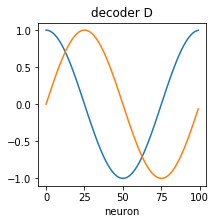

In [27]:
np.random.seed(1)
SM = spiking()
SM.par(tmax, dt, timed, n_step, MOD.ydim, nu, mu, lbd_d, lbd_v, decoderscaling, J=MOD.xdim)
X = np.zeros(ma_x.shape)*np.nan
c = np.zeros(ma_x.shape)*np.nan
dmembr = np.zeros(MOD.y.shape)*np.nan
dspikes = np.zeros(MOD.y.shape)*np.nan

Omega, T, D = SM.connect(Dtyp='hetero') # MOD.C.T) # 
plt.figure(figsize=(3,3))
plt.plot(D.T)
plt.title('decoder D')
plt.xlabel('neuron')

In [ ]:
a = ma_x.copy()

In [53]:
tt = 0
X[:,:,tt], c[:,:,tt] = SM.signal('LDS', ma_x[:,:,tt]) # 
print(c.shape)
O, V, R, X_hat = SM.mixednet(c[:,:,tt], D, Omega, T, seed=0, thresh_nois_sig=.2)    

(2, 50000, 10)


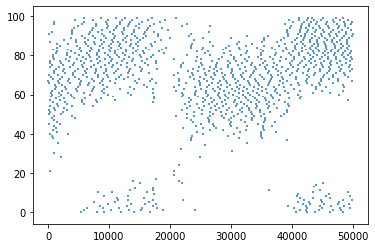

In [54]:
plt.figure()
spksT = np.arange(O.shape[1])
spks = [spksT[O[i, :]>0] for i in range(O.shape[0])]
plt.eventplot(spks);


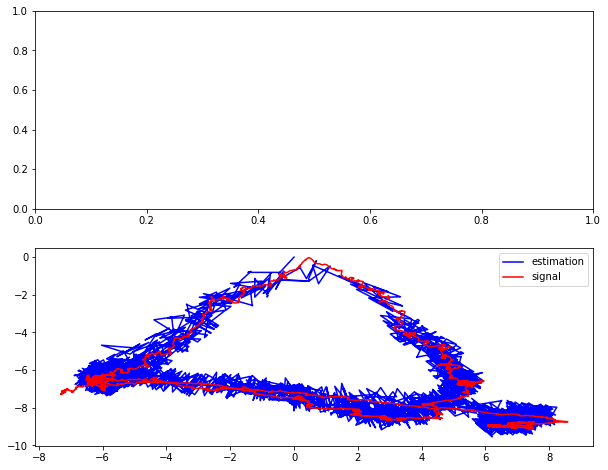

In [55]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
#tim = np.arange(0, tmax, dt)
#rasterplot(O, ax[0], tim)
ax[1].plot(X_hat[0,:], X_hat[1,:], 'b', label='estimation');
ax[1].plot(X[0,:,0], X[1,:,0], 'r', label='signal');
ax[1].legend()

ValueError: x and y must have same first dimension, but have shapes (50000,) and (2, 50000)

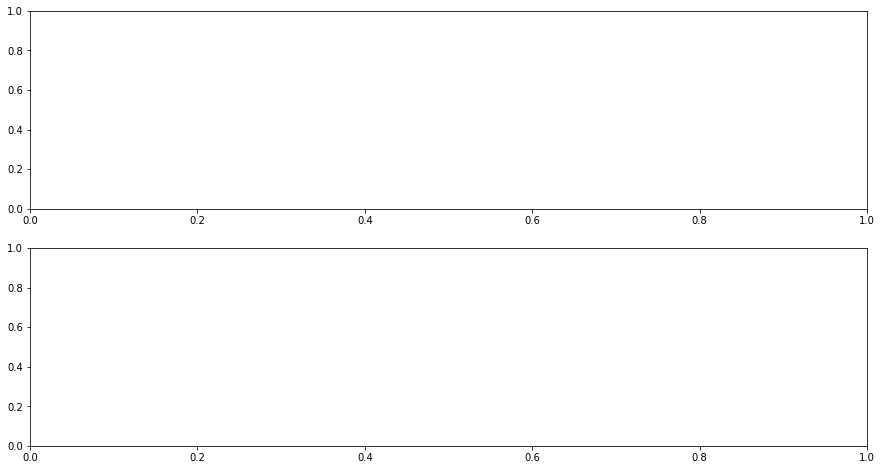

In [30]:
fig, ax = plt.subplots(2,1, figsize=(15,8))
#tim = np.arange(0, tmax, dt)
#rasterplot(O, ax[0], tim)
ax[1].plot(np.arange(0,tmax, dt), X_hat, 'b', label='estimation');
ax[1].plot(np.arange(0,tmax, dt), X[0,:,tt], 'r', label='signal');
ax[1].legend()

### simulate for all trials

In [31]:
np.random.seed(1)
#Omega, T, D = SM.connect(Dtyp=Cold[:,0]*100) # MOD.C.T) # 
for tt in range(MOD.Ttrials):
    print('trial '+np.str(tt))
    X[:,:,tt], c[:,:,tt] = SM.signal('LDS', ma_x[:,:,tt]) # 
    O, V, R, X_hat = SM.mixednet(c[:,:,tt], D, Omega, T, seed=tt)    
    # translate into binned/rate form
    dsamp = np.arange(0, n_step, 1/dt*dtsign)
    dtim = timed[dsamp.astype(int)]
    # optionally smooth through binning and averaging
    for ii in range(len(dsamp)):
        dspikes[ii,:,tt] = np.sum(O[:,np.int(dsamp[ii]):np.int(dsamp[ii]+1/dt*dtsign-1)], axis=1)
    for ii in range(len(dsamp)):
        dmembr[ii,:,tt] = np.mean(V[:,np.int(dsamp[ii]):np.int(dsamp[ii]+1/dt*dtsign-1)], axis=1)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


Text(0.5, 0, 'time')

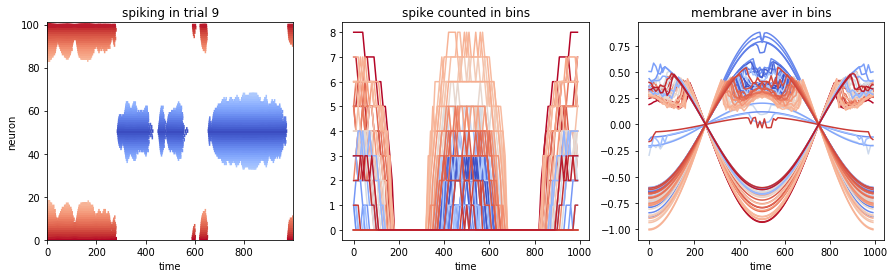

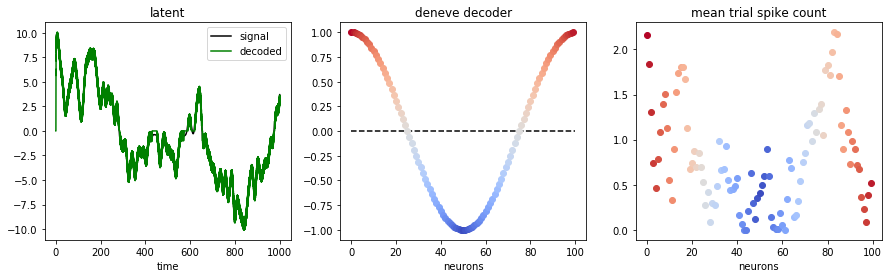

In [33]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
fig2, ax2 = plt.subplots(1,3, figsize=(15,4))
rasterplot(O, ax[0], tim=np.arange(0,tmax,dt))
ax[0].set_xlabel('time')
ax[1].set_xlabel('time')
ax[2].set_xlabel('time')
ax[0].set_ylabel('neuron')
'''ax[0].plot(timed, np.sum(O, axis=0));
ax[0].set_ylabel('summed population spikes')'''
ax2[1].plot([0, MOD.ydim], [0,0], '--k')
for nn in range(MOD.ydim):
    ax[1].plot(np.arange(0,tmax, dtsign), dspikes[nn,:,tt], color=plt.cm.coolwarm(np.abs(nn-MOD.ydim/2)/(MOD.ydim/2)));
    ax[2].plot(np.arange(0,tmax, dtsign), dmembr[nn,:,tt], color=plt.cm.coolwarm(np.abs(nn-MOD.ydim/2)/(MOD.ydim/2)));
    ax2[1].plot(nn, D[nn], 'o', color=plt.cm.coolwarm(np.abs(nn-MOD.ydim/2)/(MOD.ydim/2)));
    ax2[2].plot(nn, np.mean(dspikes[nn,:,tt]), 'o', color=plt.cm.coolwarm(np.abs(nn-MOD.ydim/2)/(MOD.ydim/2)));
ax[0].set_title('spiking in trial '+np.str(tt))
ax2[0].plot(np.arange(0,tmax, dt), ma_x[0,:,tt], 'k', label='signal');
_,_,_, X_hat = SM.mixednet(c[:,:,tt], D, Omega, T, seed=0) 
ax2[0].plot(np.arange(0,tmax, dt), X_hat, 'g', label='decoded');
ax2[0].legend()
ax2[2].set_title('mean trial spike count')
ax2[1].set_title('deneve decoder')
ax2[0].set_title('latent')
ax[1].set_title('spike counted in bins')
ax[2].set_title('membrane aver in bins')
ax2[2].set_xlabel('neurons')
ax2[1].set_xlabel('neurons')
ax2[0].set_xlabel('time')

In [34]:
if 'yold' not in locals():
    yold = np.copy(MOD.y)
if 'Cold' not in locals():
    Cold = np.copy(MOD.C)

In [35]:
for tt in range(MOD.Ttrials):
    MOD.y[:,:,tt] = dspikes[:,:,tt]/np.nanmax(dspikes)*np.nanmax(yold[:,:,tt])
# optionally also change C?
if MOD.xdim==2:
    MOD.C = D.T*np.max(Cold)/np.max(D)
if MOD.xdim==1:
    MOD.C[:,0] = D*np.max(Cold)/np.max(D)
#pickle.dump(MOD, open(path + 'model_deneveencoding_'+DtM.name + '.pk', 'wb'))

Text(0.5, 0, 'time')

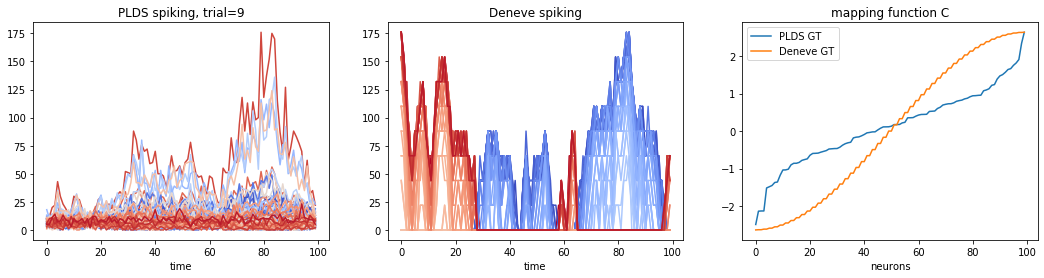

In [38]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))
for nn in range(MOD.ydim):
    ax[1].plot(MOD.y[:,nn,tt], color=plt.cm.coolwarm(np.abs(nn-MOD.ydim/2)/(MOD.ydim/2)));
    ax[0].plot(yold[:,nn,tt], color=plt.cm.coolwarm(np.abs(nn-MOD.ydim/2)/(MOD.ydim/2)));
ax[0].set_title('PLDS spiking, trial='+np.str(tt))
ax[1].set_title('Deneve spiking')
ax[2].plot(np.sort(Cold[:,0]), label='PLDS GT')
ax[2].plot(np.sort(MOD.C[:,0]), label='Deneve GT')
ax[2].legend()
ax[2].set_xlabel('neurons')
ax[2].set_title('mapping function C')
ax[0].set_xlabel('time')
ax[1].set_xlabel('time')

# Decoding latent dynamics of input using PLDS (from Deneve encoded spikes)

### estimation of latent given GT parameters (just inference)

[autoreload of PLDS_Macke2015 failed: Traceback (most recent call last):
  File "/Users/carolinehaimerl/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/carolinehaimerl/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/carolinehaimerl/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/carolinehaimerl/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/carolinehaimerl/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/Users/carolinehaimerl/opt/anaconda3/lib/python3.7/site-packages/IPython/ext

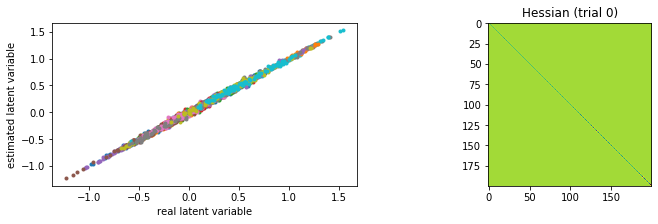

In [36]:
#Ctmp = np.copy(MOD.C)
#MOD.C[:,0] = np.copy(Ctmp) # np.random.randn(MOD.ydim)
MOD.estx = vis_est_latent(MOD)

Text(0, 0.5, 'estimated')

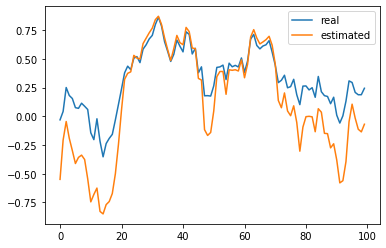

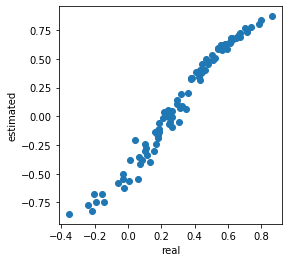

In [43]:
tt = 0
plt.figure()
plt.plot(MOD.x[:,:,tt], label='real')
plt.plot(MOD.estx[:,:,tt], label='estimated')
plt.legend()

plt.figure(figsize=(4,4))
plt.plot(MOD.x[:,:,tt], MOD.estx[:,:,tt], 'o')
plt.xlabel('real')
plt.ylabel('estimated')

### Parameter estimation

In [47]:
''' # code missing to run this
data_test = DATA()
data_test.par(coFR=0, remov=False, path_get=None, path_save='/results_tmp/',
            data_trial=MOD.y, mfr=np.mean(np.nanmean(MOD.y,axis=0),axis=1), D=MOD.ydim, Ttrials=MOD.Ttrials, 
         X=1*(np.isnan(MOD.x[:,0,:])==False).reshape(MOD.x.shape[0],1,MOD.x.shape[2]),
         counts0=MOD.n_step, simulate=False)

DtM_test = DATAtoMODEL()
DtM_test.par(data=data_test, path=path,
        saveresults=True, seed=0,MINDIM=1, MAXDIM=1, Ncrossval=1,
         scalQ=.01, scalQ0=.001, maxiter=10, maxtim=1000, difflikthresh=.0001,
         upx0=True, upQ0=True, upQ=True, upA=True, upC=True, upB=True, Adiag=False, regA=True,
         backtracking=True, backtrack_diff=0, versionadd='deneveenc2')

DtM_test.PLDS_model(data_test, saveresults=True)

_ = DtM_test.PLDS_computeMSE(data_test, saveresults=True, printit=True)'''

" # code missing to run this\ndata_test = DATA()\ndata_test.par(coFR=0, remov=False, path_get=None, path_save='/results_tmp/',\n            data_trial=MOD.y, mfr=np.mean(np.nanmean(MOD.y,axis=0),axis=1), D=MOD.ydim, Ttrials=MOD.Ttrials, \n         X=1*(np.isnan(MOD.x[:,0,:])==False).reshape(MOD.x.shape[0],1,MOD.x.shape[2]),\n         counts0=MOD.n_step, simulate=False)\n\nDtM_test = DATAtoMODEL()\nDtM_test.par(data=data_test, path=path,\n        saveresults=True, seed=0,MINDIM=1, MAXDIM=1, Ncrossval=1,\n         scalQ=.01, scalQ0=.001, maxiter=10, maxtim=1000, difflikthresh=.0001,\n         upx0=True, upQ0=True, upQ=True, upA=True, upC=True, upB=True, Adiag=False, regA=True,\n         backtracking=True, backtrack_diff=0, versionadd='deneveenc2')\n\nDtM_test.PLDS_model(data_test, saveresults=True)\n\n_ = DtM_test.PLDS_computeMSE(data_test, saveresults=True, printit=True)"

## regular Kalman Filter (single trial estimation)

In [58]:
kf = KalmanFilter(n_dim_obs=MOD.ydim, n_dim_state=MOD.xdim)#, 
                  #observation_covariance=np.eye(MOD.ydim)*np.mean(np.nanmean(MOD.y,axis=0),axis=1))
tt = 1 # a training trial
kf.em(MOD.y[:,:,tt], em_vars=['transition_covariance', 'transition_matrices', 'observation_matrices',
                     'initial_state_mean', 'initial_state_covariance', 'observation_covariance'])
tt = 2 # a testing trial
smoothed_state_means, smoothed_state_covariances = kf.smooth(MOD.y[:,:,tt])

KF correlation 0.652
PLDS correlation 0.958


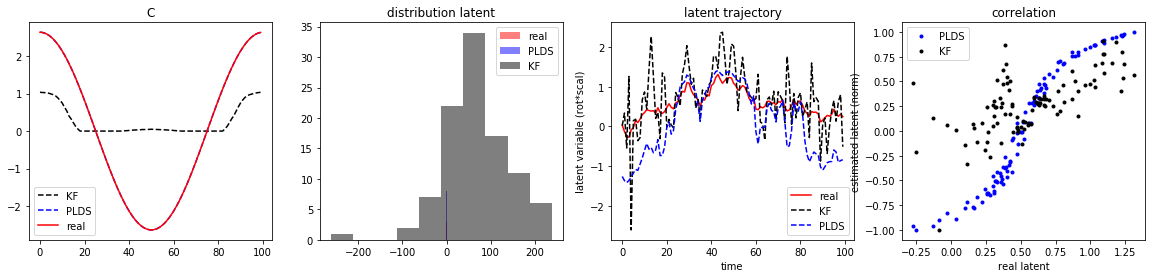

In [59]:
[c1, c2] = MOD.visfitting(smoothed_state_means, Xfin=MOD.estx[:,:,tt], scal_kal=.01, scal_plds=1, 
                          C_KF=kf.observation_matrices, C_PLDS=MOD.C, ttrial=tt)

Text(0.5, 1.0, 'high FR neuron 0')

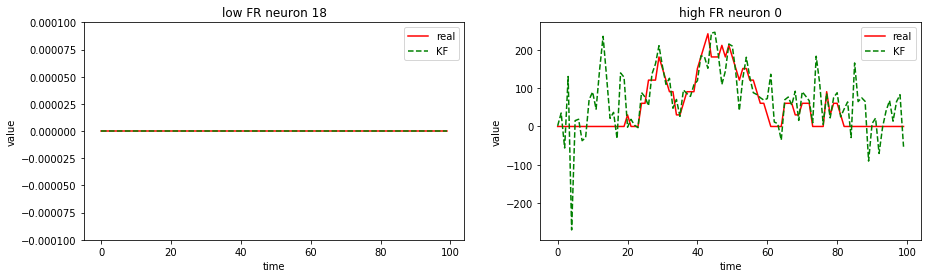

In [60]:
pred_KF = kf.observation_matrices.dot(smoothed_state_means.T).T

fig, ax = plt.subplots(1,2, figsize=(15,4))
nn = np.argmin(np.mean(np.nanmean(MOD.y, axis=0), axis=1))
ax[0].plot(MOD.y[:,nn,tt],'-r', label='real');
ax[0].plot(pred_KF[:,nn],'--g', label='KF');
ax[0].set_xlabel('time')
ax[0].set_ylabel('value')
ax[0].legend()
ax[0].set_title('low FR neuron '+np.str(nn))
ax[0].set_ylim(-.0001, .0001)

nn = np.argmax(np.mean(np.nanmean(MOD.y, axis=0), axis=1))
ax[1].plot(MOD.y[:,nn,tt],'-r', label='real');
ax[1].plot(pred_KF[:,nn],'--g', label='KF');
ax[1].set_xlabel('time')
ax[1].set_ylabel('value')
ax[1].legend()
ax[1].set_title('high FR neuron '+np.str(nn))

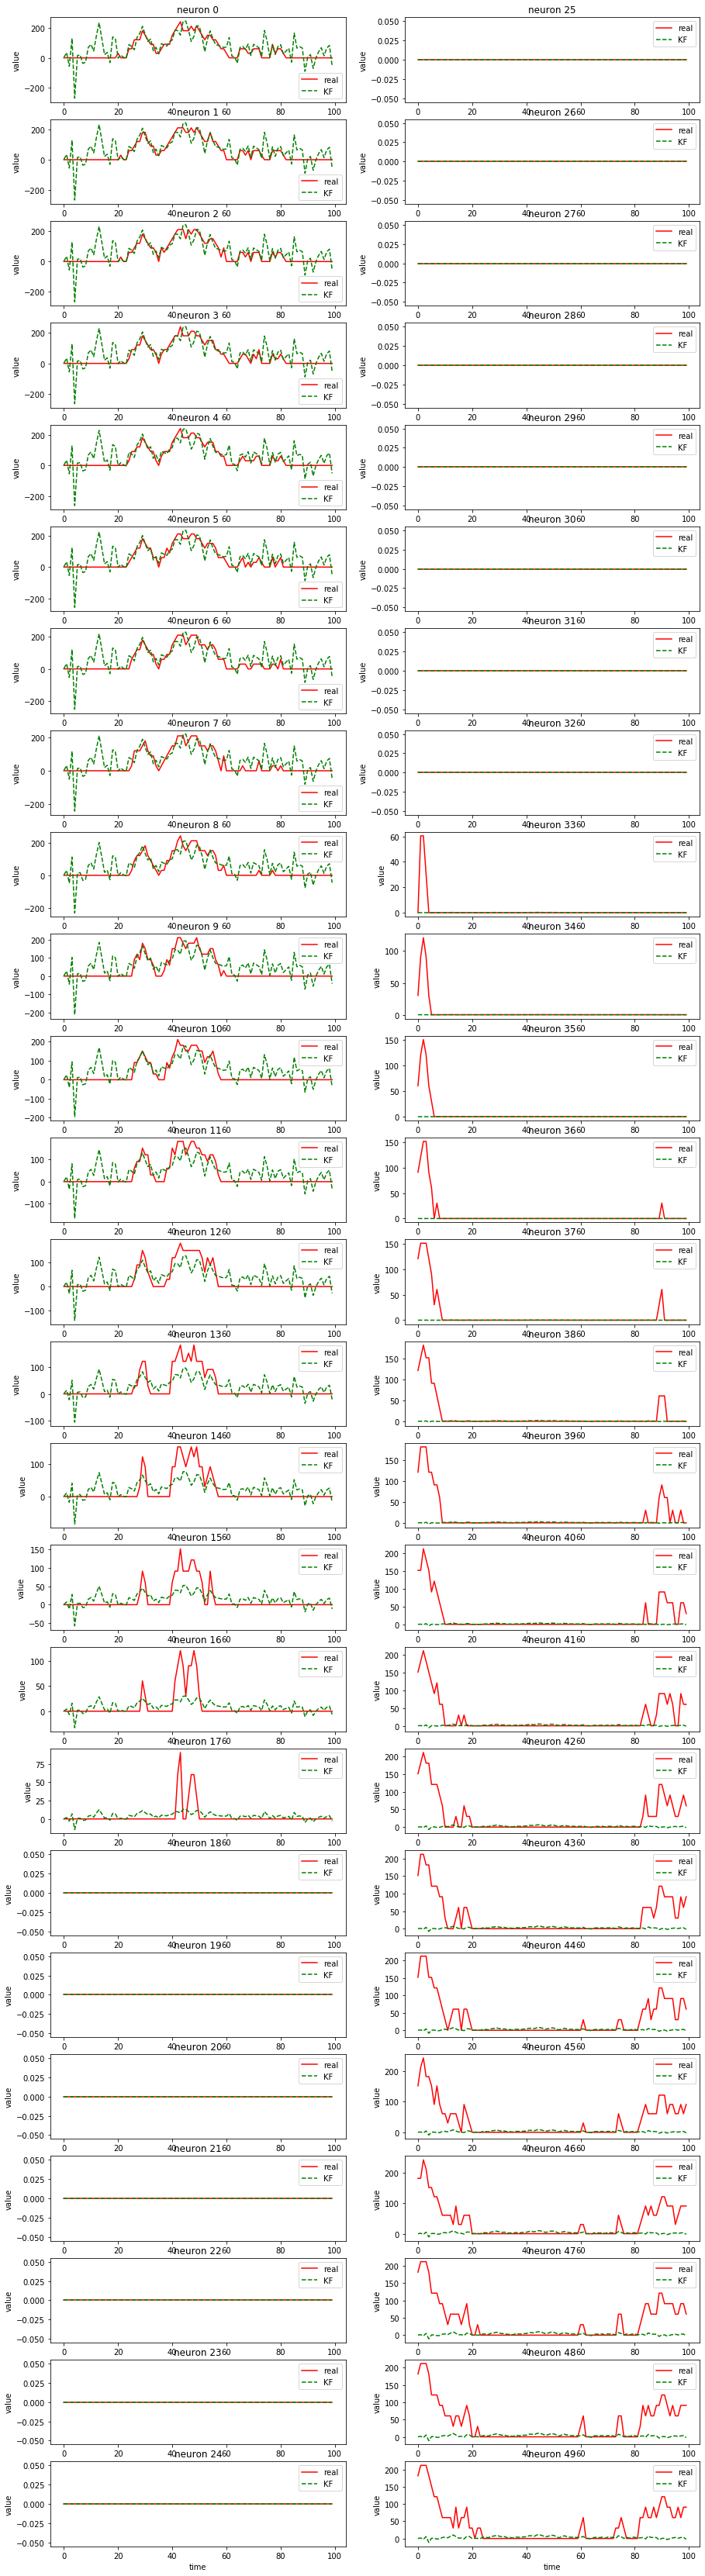

In [61]:
Nshow = 50
Nhalf = 25
fig, ax = plt.subplots(Nhalf,2, figsize=(15,60))
for nn in range(Nshow):
    ax[nn-Nhalf*(nn>=Nhalf),(nn>=Nhalf)*1].plot(MOD.y[:,nn,tt],'-r', label='real');
    ax[nn-Nhalf*(nn>=Nhalf),(nn>=Nhalf)*1].plot(pred_KF[:,nn],'--g', label='KF');
    ax[nn-Nhalf*(nn>=Nhalf),(nn>=Nhalf)*1].set_xlabel('time')
    ax[nn-Nhalf*(nn>=Nhalf),(nn>=Nhalf)*1].set_ylabel('value')
    ax[nn-Nhalf*(nn>=Nhalf),(nn>=Nhalf)*1].legend()
    ax[nn-Nhalf*(nn>=Nhalf),(nn>=Nhalf)*1].set_title('neuron '+np.str(nn))
